In [1]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
import os
from pathlib import Path
from datetime import datetime

In [2]:
# eigene Utils
from utils.addTimeInformation import addTimeInformation
from utils.combineDataFrames import combineDataFrames
from utils.extraploation_class import Extrapolation
from utils.plotCalendarHeatmap import plotCalendarHeatmap
from utils.read_CSV import *
from utils.calcDifference import differenceBetweenDataframes, StorageIntegration
from utils.calculateConsumption import calculateConsumption, getConsumptionYear

In [3]:
# Faktoren, Variablen

consumption_development_rate = 1.05
CO2_factor_Kohle = 0.35
CO2_factor_Gas = 0.2
share_coal = (100/39*23)/100
share_gas = (100/39*16)/100

# CSV einlesen (Erzeugung)

In [4]:
#alle Daten ab 2015 einlesen
directory_yearly_generation = getData("Erzeugung")

# Daten extrapolieren 2024 bis 2030
for year in range(2024,2031):
    prev_year_df =directory_yearly_generation.get(year-1).copy()    #Kopie des Dataframe des letzten Jahres
    extrapolated_data = Extrapolation(prev_year_df, year, 1.05, 1.03, 1.04)        #Erstellung eines neuen Objekts, mit einem DataFrame
    directory_yearly_generation[extrapolated_data.year]= extrapolated_data.df   #DataFrame in das Erzeugungsverzeichnis gespeichert wird


Data für 2015 loaded succsessfully.
Data für 2016 loaded succsessfully.
Data für 2017 loaded succsessfully.
Data für 2018 loaded succsessfully.
Data für 2019 loaded succsessfully.
Data für 2020 loaded succsessfully.
Data für 2021 loaded succsessfully.
Data für 2022 loaded succsessfully.
Data für 2023 loaded succsessfully.


# Erzeugung 2030 (Gesamt)

In [5]:
# Lade die Daten für das Jahr 2030
df_2030 = directory_yearly_generation.get(2030)

# Überprüfe, ob die Spalten vorhanden sind
required_columns = ['Wind Offshore', 'Wind Onshore', 'Photovoltaik']
if all(column in df_2030.columns for column in required_columns):
    # Berechne die Summe der gewünschten Spalten für jede 15-Minuten-Periode
    df_2030['Gesamterzeugung_EE'] = df_2030[required_columns].sum(axis=1)
    
    # Speichere die Ergebnisse in production_2030
    production_2030 = df_2030[['Datum', 'Gesamterzeugung_EE']]
    
    #print(production_2030)
else:
    print("Eine oder mehrere der erforderlichen Spalten fehlen im DataFrame für 2030.")

# Verbrauch 2030 (Gesamt)

In [6]:
consumption_existing_years = calculateConsumption(consumption_development_rate)
consumption_2030 = consumption_existing_years.get(2030)

Data für 2023 loaded succsessfully.


# Differenz bilden

In [7]:
# Annahme: consumption_2030 und production_2030 sind bereits definierte DataFrames mit einer 'Datum'-Spalte und einer 'Gesamtverbrauch'-Spalte

# Überprüfe, ob beide DataFrames die gleiche Zeitachse haben

resdidual_df = differenceBetweenDataframes(consumption_2030, production_2030)

storage_df = StorageIntegration(resdidual_df, 50000, 1500)

print(resdidual_df)
print(storage_df)

TypeError: 'NoneType' object is not subscriptable

# HeatMap

c:\Users\jmend\OneDrive - HAW-HH\REE\IPJ1\SS-Programmieren\Klimaneutral-20245\utils\plotCalendarHeatmap.py:7: FutureWarning: The provided callable <function sum at 0x000002993384B6D0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  heatmap_data = df.pivot_table(index='Year Month', columns='Day', values=colName, aggfunc=np.sum)    # aggfunc=np.sum ->Werte summiert über den Tag!


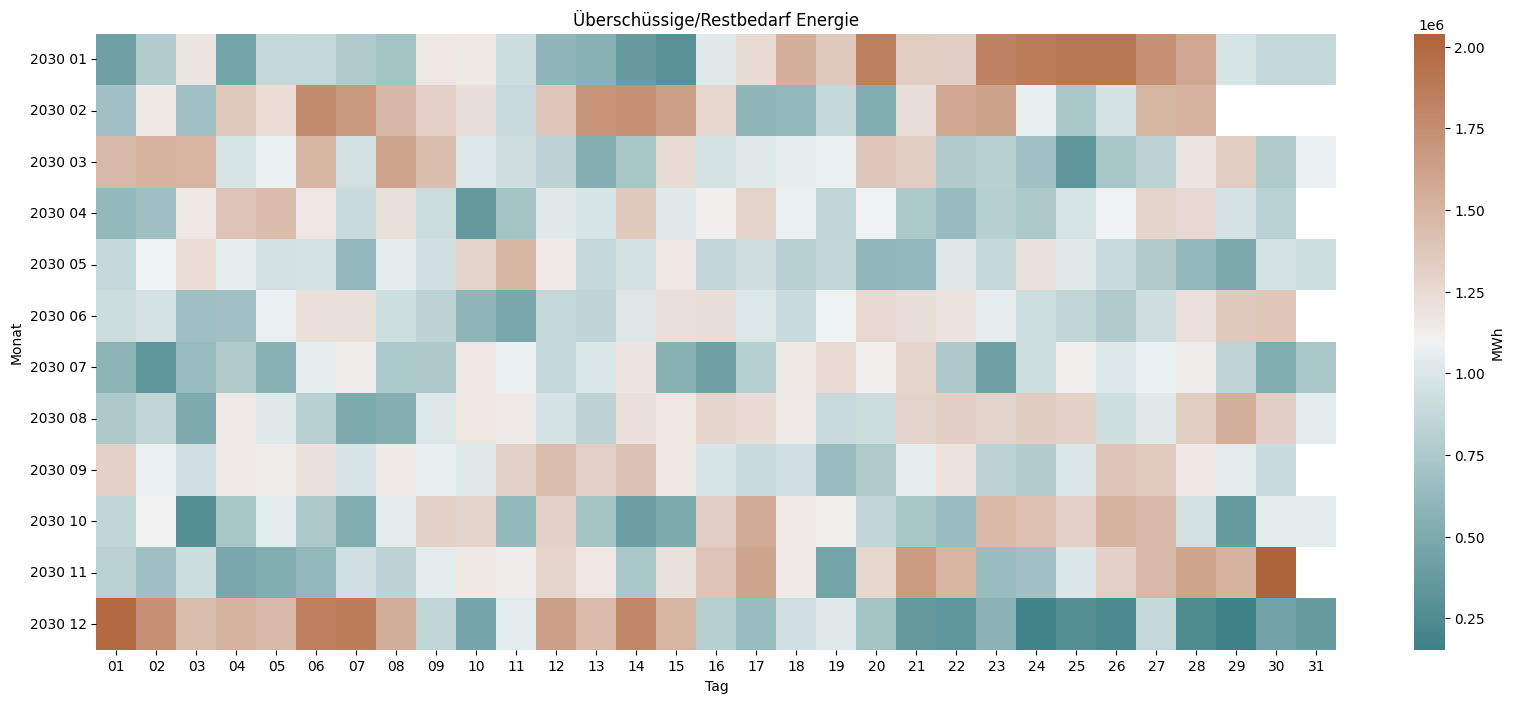

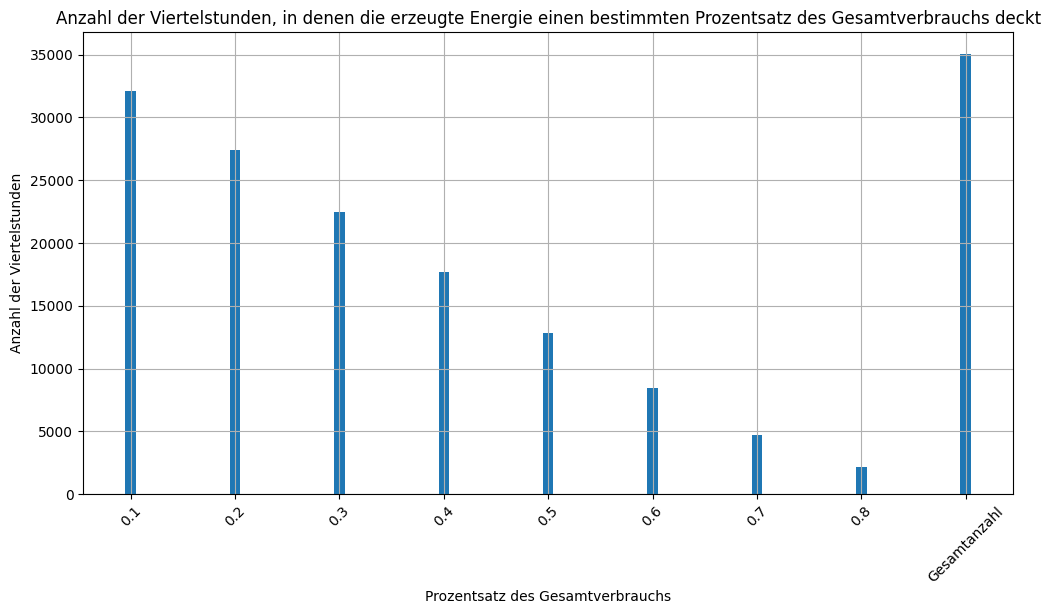

In [ ]:
plotCalendarHeatmap(resdidual_df, "Überschüssige/Restbedarf Energie", "Differenz", linewidths = 0)

# Prozentsätze definieren
percentages = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80]

# Dictionary, um die Anzahl der Viertelstunden für jeden Prozentsatz zu speichern
coverage_counts = {percentage: 0 for percentage in percentages}

# Berechne die Deckung für jede Viertelstunde
for index, row in production_2030.iterrows():
    for percentage in percentages:
        if row['Gesamterzeugung_EE'] >= percentage * consumption_2030.loc[index, 'Gesamtverbrauch']:
            coverage_counts[percentage] += 1

# Füge die Gesamtanzahl der Viertelstunden hinzu
total_quarters = len(production_2030)
coverage_counts['Gesamtanzahl'] = total_quarters

# Erstelle ein Summenhistogramm
plt.figure(figsize=(12, 6))
# Convert keys to strings for consistent data types
coverage_counts_str_keys = {str(key): value for key, value in coverage_counts.items()}

plt.bar(coverage_counts_str_keys.keys(), coverage_counts_str_keys.values(), width=0.10, align='center')
plt.xlabel('Prozentsatz des Gesamtverbrauchs')
plt.ylabel('Anzahl der Viertelstunden')
plt.title('Anzahl der Viertelstunden, in denen die erzeugte Energie einen bestimmten Prozentsatz des Gesamtverbrauchs deckt')
plt.xticks([str(key) for key in coverage_counts.keys()], rotation=45)
plt.grid(True)
plt.show()

# CO2-Bilanz bilden

In [ ]:
#Summiere die Differenz der Viertelstunden
total_residual_energy = (resdidual_df['Differenz'].sum())

print(f"Insgesamt müssen {total_residual_energy/1000} GWh über fossile Brennstoffe erzeugt werden.")

if total_residual_energy > 0:
    total_residual_energy_CO2_Kohle = total_residual_energy * CO2_factor_Kohle * share_coal
    total_residual_energy_CO2_gas = total_residual_energy * CO2_factor_Gas * share_gas 
    total_co2 = total_residual_energy_CO2_Kohle + total_residual_energy_CO2_gas
    print("Es werden insgesamt {} Tonnen CO2 emittiert. Davon sind {} Tonnen CO2 aus Kohle und {} Tonnen CO2 aus Gas.".format(total_co2, total_residual_energy_CO2_Kohle, total_residual_energy_CO2_gas))
elif total_residual_energy < 0:
    print("Es wird kein CO2 emittiert.")
else:
    print("Es liegt ein Fehler in der Berechnung vor.") 

Insgesamt müssen 375593.0192731712 GWh über fossile Brennstoffe erzeugt werden.
Es werden insgesamt 108344140.17495322 Tonnen CO2 emittiert. Davon sind 77526251.41407764 Tonnen CO2 aus Kohle und 30817888.76087559 Tonnen CO2 aus Gas.


# User-Info